In [1]:
from importlib import reload
from libs import io , cv2 , np

import preprocessing as pp
import roi as roi
import detection as detect
from classifier import H3T_Classifier
from numbers_classifier import H3T_Numbers_Classifier
import videoread as vr
import cameraread as cr
from skimage import filters

In [2]:

reload(roi)
reload(detect)
reload(vr)
reload(cr)

<module 'cameraread' from 'd:\\IP\\project\\real\\app\\flask-server\\cameraread.py'>

In [3]:
# INIT

sign_imgs_corr = detect.get_corrleation_matrices("../../dataset/corr_signs")


In [4]:
numbers_classifier = H3T_Numbers_Classifier()

In [5]:
numbers_classifier.prepare_training_data("../../dataset/standard_numbers/training_data")

digit 0 done
digit 1 done


error: OpenCV(4.6.0) :-1: error: (-5:Bad argument) in function 'resize'
> Overload resolution failed:
>  - src data type = 17 is not supported
>  - Expected Ptr<cv::UMat> for argument 'src'


In [11]:
numbers_classifier.train("svm")

In [51]:
numbers_classifier.save_trained_model()

In [5]:
numbers_classifier.load_trained_model()

In [6]:
import os

videos_folder = '../../dataset/videos'
video_frames_folder = '../../dataset/video_frames'


In [49]:
#convert videos to frames
vr.clear_folder(video_frames_folder)
for video_path in os.listdir(videos_folder):
    vr.extract_frames(video_path = os.path.join(videos_folder , video_path), output_folder = video_frames_folder, fps=5)



Frame 0 saved to ../../dataset/video_frames/frame_0.jpg
Frame 5 saved to ../../dataset/video_frames/frame_5.jpg
Frame 10 saved to ../../dataset/video_frames/frame_10.jpg
Frame 15 saved to ../../dataset/video_frames/frame_15.jpg
Frame 20 saved to ../../dataset/video_frames/frame_20.jpg
Frame 25 saved to ../../dataset/video_frames/frame_25.jpg
Frame 30 saved to ../../dataset/video_frames/frame_30.jpg
Frame 35 saved to ../../dataset/video_frames/frame_35.jpg
Frame 40 saved to ../../dataset/video_frames/frame_40.jpg
Frame 45 saved to ../../dataset/video_frames/frame_45.jpg
Frame 50 saved to ../../dataset/video_frames/frame_50.jpg
Frame 55 saved to ../../dataset/video_frames/frame_55.jpg
Frame 60 saved to ../../dataset/video_frames/frame_60.jpg
Frame 65 saved to ../../dataset/video_frames/frame_65.jpg
Frame 70 saved to ../../dataset/video_frames/frame_70.jpg
Frame 75 saved to ../../dataset/video_frames/frame_75.jpg
Frame 80 saved to ../../dataset/video_frames/frame_80.jpg
Frame 85 saved to 

In [7]:
# detect number of logical cpus
import multiprocessing

num_cpus = multiprocessing.cpu_count()
print("Number of logical CPUs:", num_cpus)

Number of logical CPUs: 12


In [11]:
def process_label(labels , label, thresh , charCandidates):
    # if this is the background label, ignore it
    if label == 0:
        return

    # otherwise, construct the label mask to display only connected components for the
    # current label, then find contours in the label mask
    labelMask = np.zeros(thresh.shape, dtype="uint8")
    labelMask[labels == label] = 255


    cnts = cv2.findContours(labelMask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]

    contour = max(cnts, key=cv2.contourArea)
    boxX, boxY, boxW, boxH = cv2.boundingRect(contour)

    # compute the aspect ratio, solidity, and height ratio for the component
    aspectRatio = boxW / float(boxH)
    solidity = cv2.contourArea(contour) / float(boxW * boxH)
    heightRatio = boxH / float(thresh.shape[0])

    #print(solidity)

    # determine if the aspect ratio, solidity, and height of the contour pass
    # the rules tests
    keepAspectRatio = aspectRatio < 1.0
    keepSolidity = solidity > 0.2
    keepHeight = heightRatio > 0.3 and heightRatio < 0.95

    # check to see if the component passes all the tests
    if keepAspectRatio and keepSolidity and keepHeight:
        charCandidates.append((boxX, boxY, boxW, boxH))

In [12]:
import threading
from skimage import measure
def segement_numbers(image):
    V = cv2.cvtColor(image , cv2.COLOR_BGR2HSV)[: ,: , 2]
    T = filters.threshold_local(V, 27, offset=5, method="gaussian")
    thresh = (V > T).astype("uint8") * 255
    thresh = cv2.bitwise_not(thresh)
    inverted_thresh = cv2.bitwise_not(thresh)
    pp.show_images([image , thresh])
    # perform a connected components analysis and initialize the mask to store the locations
    # of the character candidates
    charCandidates = []
    labels = measure.label(thresh, background=0)
    threads = []
    for label in np.unique(labels):
        thread = threading.Thread(target=process_label, args=(labels , label, thresh , charCandidates))
        thread.start()
        threads.append(thread)
     
    # Wait for all threads to finish
    for thread in threads:
        thread.join()
            
    imagess = []

    charCandidateslen = len(charCandidates)
    if (charCandidateslen < 2 or charCandidateslen > 3):
        print("wrong sign detected with length = " , len(charCandidates))
        return None
    
    for i in range(charCandidateslen):
        new_image = inverted_thresh[charCandidates[i][1]:charCandidates[i][1]+charCandidates[i][3] , charCandidates[i][0]:charCandidates[i][0]+charCandidates[i][2]]
        new_image = cv2.resize(new_image, (16, 32))
        pp.show_images([new_image], [f"new_image {i}"])
        prediction = numbers_classifier.predict(new_image)
        imagess.append((charCandidates[i][0] , prediction[0].astype(int)))
    
    #sort by the x coordinate
    imagess.sort(key=lambda x: -x[0])
    
    result = np.sum([imagess[i][1]*(10**i) for i in range(len(imagess))])
        
    return result

1


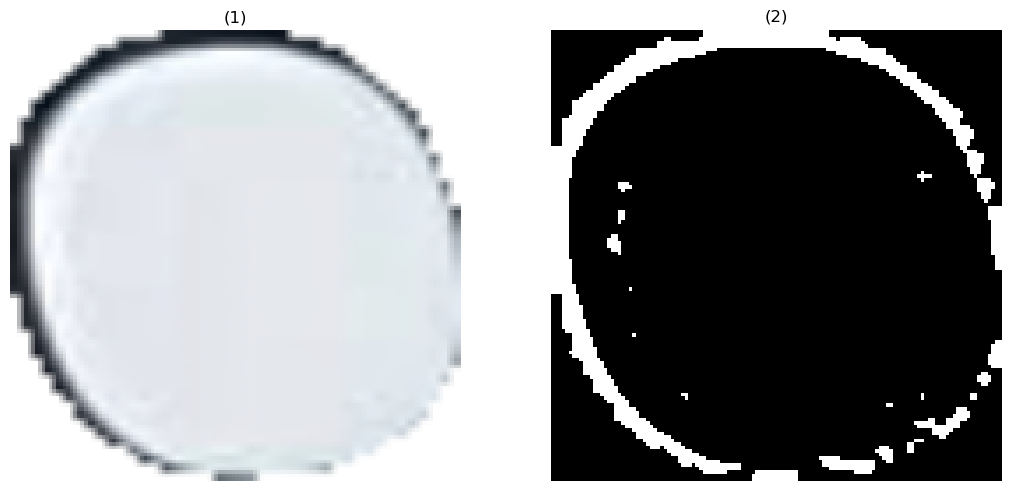

wrong sign detected with length =  0
-1
no sign detected
0


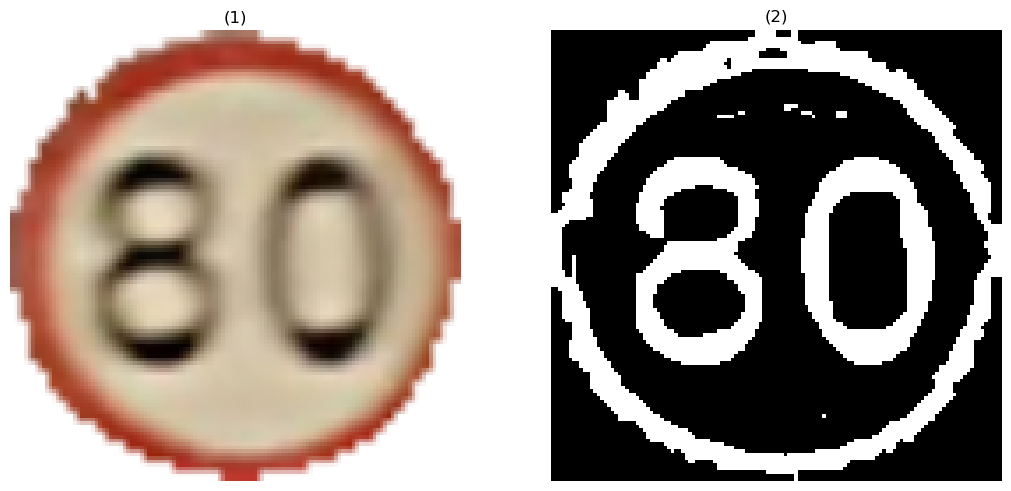

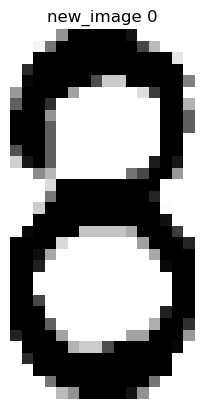

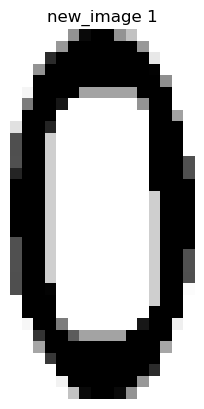

result = 80
3


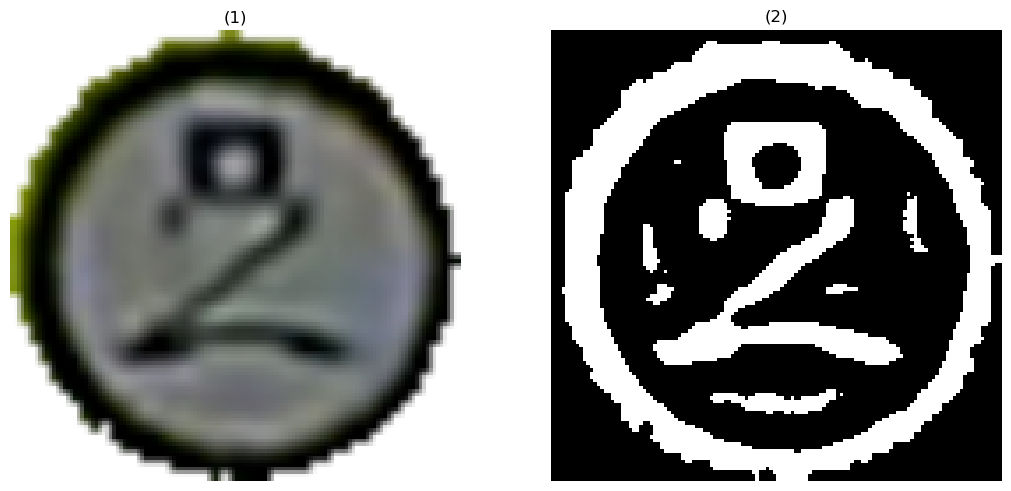

wrong sign detected with length =  0
0


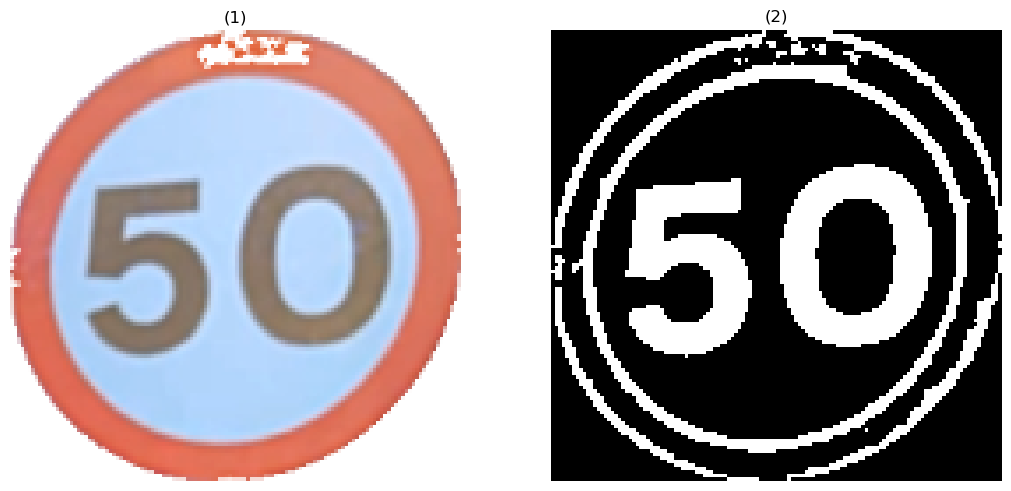

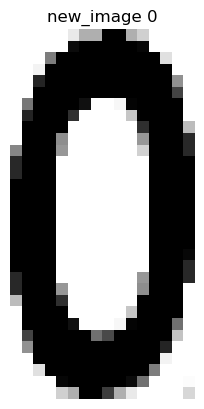

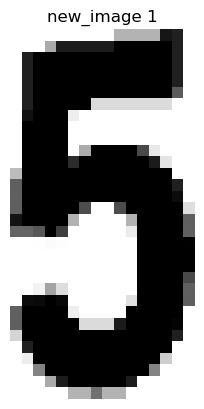

result = 50
1


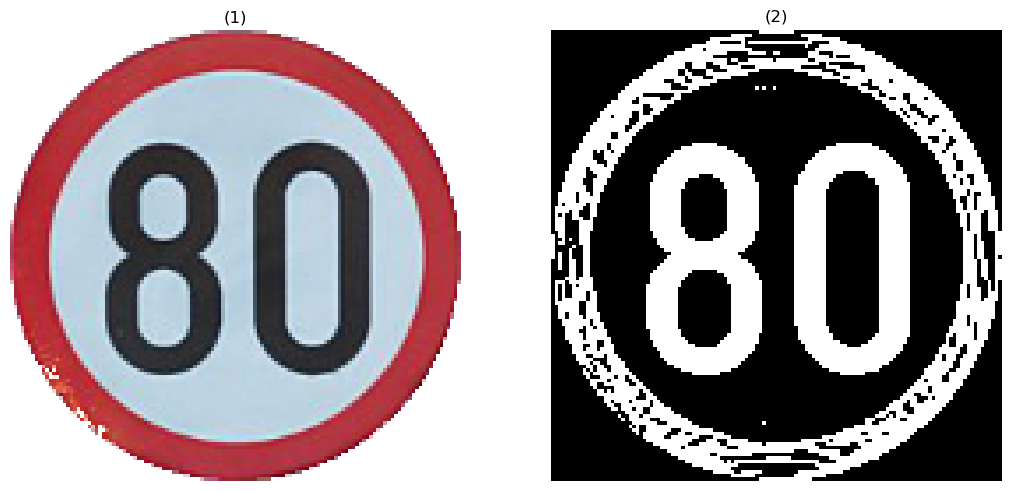

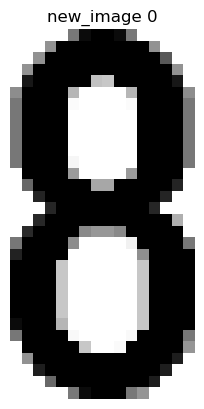

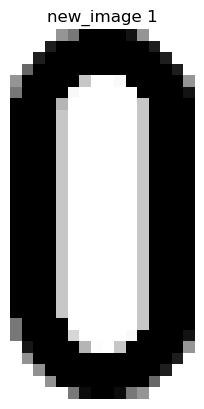

result = 80
1


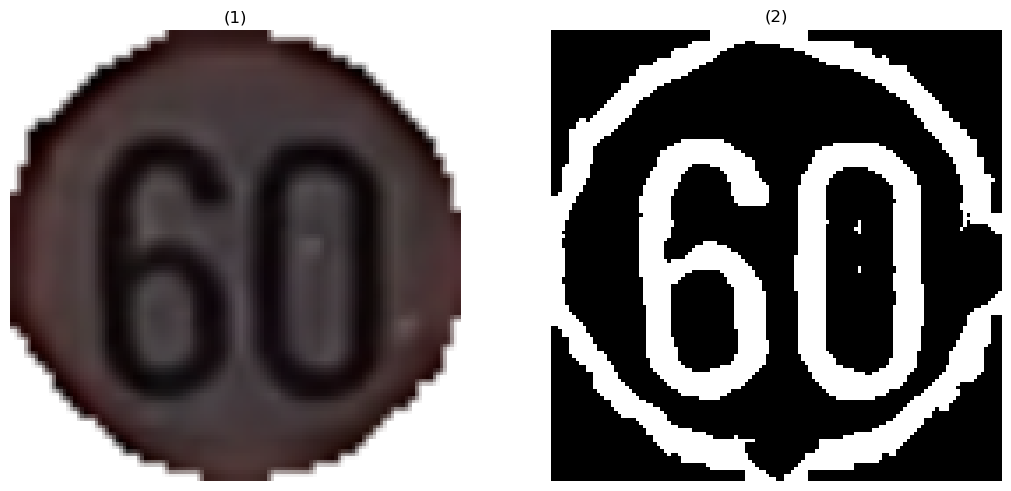

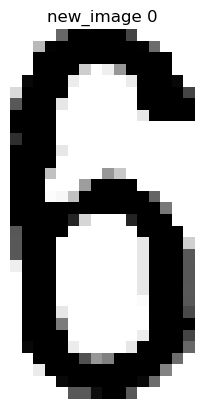

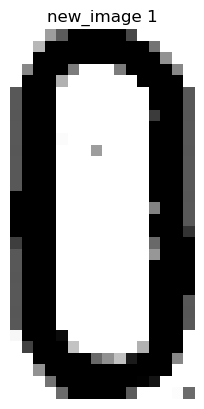

result = 60


In [13]:


#read images from video_frames_folder
other_test_cases_path = "../../dataset/gilany_dataset"

for image_path in os.listdir(other_test_cases_path):

    image = io.imread(os.path.join(other_test_cases_path, image_path))

    resized_img = cv2.resize(image, (1280, 720))

    # pp.show_images([resized_img], ["resized_img Image"])

    cropped_img = cv2.hconcat([resized_img[:, :(resized_img.shape[1] // 3)]  , resized_img[:, 2 * (resized_img.shape[1] // 3):]])

    # Convert the image to grayscale
    gray_image = pp.gray_image(resized_img)
    # pp.show_images([gray_image], ["Gray Image"])

    equalized_image = pp.HistogramEqualization(gray_image)

    # Apply edge detection
    edge_image = pp.LoGEdgeDetection(equalized_image)

    # Extract ROIs
    rois = roi.extract_roi(edge_image , resized_img)

    #pp.show_images(rois)

    ## detect sign
    if (len(rois)  == 0):
        print("no rois")
        continue
    else:
        detected_image_index = detect.detect_sign(rois, sign_imgs_corr)
        print(detected_image_index) 
        if detected_image_index != -1:





            # new_image = pp.gray_image(rois[detected_image_index])

            # # #perform opening
            # kernel = np.ones((2,2), np.uint8)
            # new_image = cv2.erode(new_image, kernel, iterations=2)
            # new_image = cv2.dilate(new_image, kernel, iterations=1)
            
            # cropped_img = new_image[ 30:100 , 25:61 ]
            # resized_img = cv2.resize(cropped_img, (16, 32))

            # threshold = filters.threshold_otsu(resized_img)
            # thresholded_image = np.zeros(resized_img.shape)
            # thresholded_image[resized_img  > threshold] = 1
            # blurred_threshold_image = filters.gaussian(thresholded_image , sigma=0.7)

            # # show everything
            # pp.show_images([new_image , thresholded_image , blurred_threshold_image])

          

            result = segement_numbers(rois[detected_image_index])
            if (result != None):
                print(f'result = {result}')

        else:
            print("no sign detected")
            continue

    # wait for 'n' key else 
    #if(cv2.waitKey(1) & 0xFF == ord('n')): pass


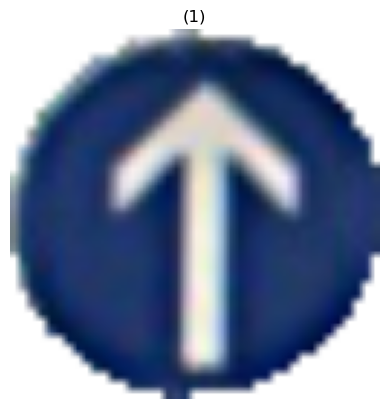

In [19]:

# Extract ROIs
rois = roi.extract_roi(edge_image , resized_img)

# print(rois[0].shape)
#show rois

# new_images = []
# for i in range(len(rois)):
#     #  rois[i] = pp.gray_image(rois[i])
#      new_images.append(pp.HistogramEqualization(rois[i]))

pp.show_images(rois)

In [20]:
if (len(rois)  == 0):
    print("no rois")
else:
    detected_image_index = detect.detect_sign(rois, sign_imgs_corr)
    print(detected_image_index) 
    if detected_image_index != -1:
        
        # feature_vector , transformed_hog = hog(rois[detected_image_index] , visualize = True , channel_axis=2  , pixels_per_cell=(16, 16) , transform_sqrt=True)
        # pp.show_images([rois[detected_image_index], transformed_hog])

        # red_channel = colored_image[:, :, 0]
        # green_channel = colored_image[:, :, 1]
        # blue_channel = colored_image[:, :, 2]

        # new_image = red_channel.copy()

        # for i in range(new_image.shape[0]):
        #     for j in range(new_image.shape[1]):
        #         if (red_channel[i][j]  < 200 and green_channel[i][j] < 200 and blue_channel[i][j] < 200):
        #             new_image[i][j] = 255
        #         else:
        #             new_image[i][j] = 0

        new_image = pp.gray_image(rois[detected_image_index])


        # #perform opening
        kernel = np.ones((2,2), np.uint8)
        new_image = cv2.erode(new_image, kernel, iterations=2)
        new_image = cv2.dilate(new_image, kernel, iterations=1)
        
        cropped_img = new_image[ 30:100 , 25:61 ]
        resized_img = cv2.resize(cropped_img, (16, 32))

        threshold = filters.threshold_otsu(resized_img)
        thresholded_image = np.zeros(resized_img.shape)
        thresholded_image[resized_img  > threshold] = 1
        blurred_threshold_image = filters.gaussian(thresholded_image , sigma=0.7)

        # show everything
        pp.show_images([new_image , thresholded_image , blurred_threshold_image])
                
                

        print(f'prediction is {numbers_classifier.predict(blurred_threshold_image)}')
    else:
        print("no sign detected")


-1
no sign detected
